<a href="https://www.kaggle.com/code/mixanyy/wine-review-classification?scriptVersionId=105834340" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.model_selection import train_test_split

import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout


#show wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

#suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wine-reviews/winemag-data_first150k.csv
/kaggle/input/wine-reviews/winemag-data-130k-v2.json
/kaggle/input/wine-reviews/winemag-data-130k-v2.csv


# In this notebook, we will classify kind of wine ('variety' column) using the description provided ('description' column).  

## 1. EDA

In [46]:
#read in the datasets
#as we only need 'description' and 'variety' columns for this task, I will read only these two columns to save memory and do less computatiuon
cols = ['description', 'variety']
df_1 = pd.read_csv('../input/wine-reviews/winemag-data_first150k.csv', usecols =cols)
df_2 = pd.read_csv('../input/wine-reviews/winemag-data-130k-v2.csv', usecols = cols)

print(df_1.shape)
print(df_2.shape)

(150930, 2)
(129971, 2)


In [47]:
#let's check if there are null entries in both datasets
print(df_1.info())
print('---------------------------------')
print(df_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  150930 non-null  object
 1   variety      150930 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB
None
---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  129971 non-null  object
 1   variety      129970 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB
None


In [48]:
#seems like df_2 has one null value in 'description'. I will drop it.
df_2.dropna(axis = 0, inplace = True)

In [49]:
#now it's a good time to concatenate the datsets, so we have one dataset to deal with
df = pd.concat([df_1, df_2])
print("Shape of the dataframe" ,df.shape)

Shape of the dataframe (280900, 2)


In [50]:
#let's see how do the first couple of rows look like
df.head()

,description,variety
0,This tremendous 100% varietal wine hails from ...,Cabernet Sauvignon
1,"Ripe aromas of fig, blackberry and cassis are ...",Tinta de Toro
2,Mac Watson honors the memory of a wine once ma...,Sauvignon Blanc
3,"This spent 20 months in 30% new French oak, an...",Pinot Noir
4,"This is the top wine from La Bégude, named aft...",Provence red blend


In [51]:
#and how many varieties are there actually?
df['variety'].nunique()

756

### There are some 756 varieties of wine in the dataframe. Let's select the top 5 varieties and build a model to correctly classify them using the description column.

In [52]:
#we will take only the top 5 varieties
top_varieties = df['variety'].value_counts().head(5).index
df_top_5 = df[df['variety'].isin(top_varieties)]
df_top_5.shape

(109340, 2)

In [53]:
#let's see what are the top varieties
df_top_5['variety'].unique()

array(['Cabernet Sauvignon', 'Pinot Noir', 'Chardonnay', 'Red Blend',
       'Bordeaux-style Red Blend'], dtype=object)

### Let's have a look at what are the most used words in our dataset, and if they are relavent to the task!

In [54]:
#show wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords.words('english'),
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

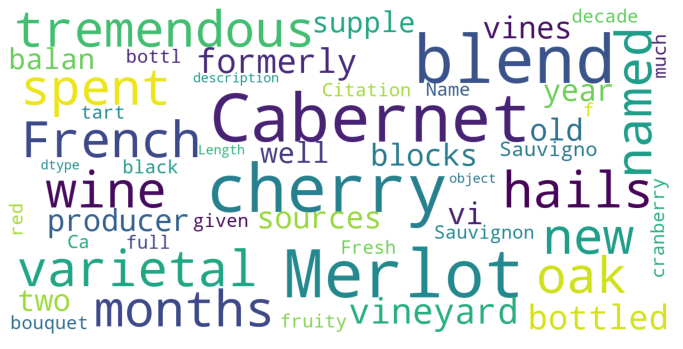

In [55]:
#show wordcloud
show_wordcloud(df_top_5['description'])

### mmm, some are relavent for sure, such as 'wine', 'vineyard', but some clearly aren't, such as: 'two', 'months'. We will do some pre-processing to the data to make it better.  

### 
- So, the thing is, neural netwroks, or machine learning models can't work on textual data. As a result, we can't just pass text data to the model. What we can do is, find a way to convert the text data to numerical data, and feed it to the model. 
- Special characters, such as: '@#%*&' don't impact the decision process, as they are quiet arbitray, so we can get rid of them from the 'description'
- 'He is a good man', 'He is a bad man'. In these two sentences, words such as: 'he', 'is', 'a', 'man' don't make any difference wheather the person is this or that. There are called stop words, and we want to get rid of them. This will save us a lot of memory and computation. 
- 'He' and 'he' are same words, we know, but a computer doesn't know that. So, instead of considering them to be two different words, we we convert all the words in their lowercasr forms. This is save us memory and computation without impacting the result.
- We will get all the words in their base form. For example: instead of considering 'go' and 'went' to be two different words, we will convert 'went' into 'go'.
- And finally, we will encode the classes as numbers. 



In [56]:
#preprocessing
def preprocess_text(df):
    #remove special characters
    df['description'] = df['description'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
    #convert to lowercase
    df['description'] = df['description'].apply(lambda x: x.lower())
    #remove stopwords
    stop_words = stopwords.words('english')
    df['description'] = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    df['description'] = df['description'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    #encode the labels
    df['variety'] = df['variety'].factorize()[0]
    return df

In [57]:
df_top_5_processed = preprocess_text(df_top_5)

### Now, let's have a look at the wordcloud again, and see if it's improved

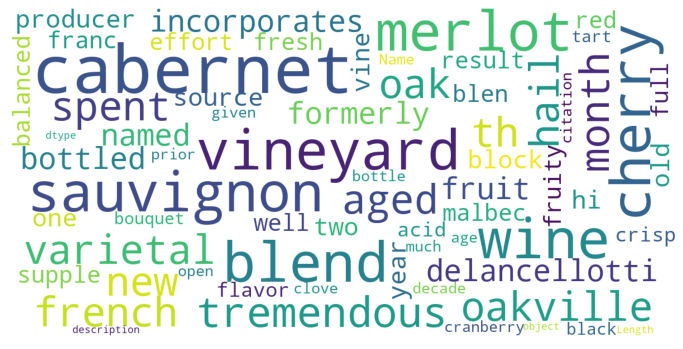

In [58]:
#show wordcloud
show_wordcloud(df_top_5_processed['description'])

# 2. Split the data, and prepare it for the training and testing

In [59]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_top_5_processed['description'], df_top_5_processed['variety'], test_size=0.2, random_state=42)

In [60]:
#check how many unique words we have
vocab_size = len(set(' '.join(X_train).split()))
print('Vocab size: ', vocab_size)

Vocab size:  20395


### There are some 20395 unique words in the whole training sample. We need to provide the number of words in our corpus, so that it can encode them with numbers. 

In [61]:
#vocab size
vocab_size = 10000 
encoded_docs_train = [one_hot(d, vocab_size) for d in X_train]
encoded_docs_test = [one_hot(d, vocab_size) for d in X_test]

### All the descriptions are not of same length for sure. So, we pad the shorter descriptions. 

In [62]:
#pad the sequences
max_length = 100
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

# 3. Model , train, test

### Model

In [64]:
#max length
max_length = 100
#embedding size
embedding_size = 32
#number of classes
num_classes = 5
#model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_length))
#bidirectional LSTM
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 336,965
Trainable params: 336,965
Non-trainable params: 0
_________________________________________________________________


### Train

In [65]:
#train the model
model.fit(padded_docs_train, y_train, epochs=10, verbose=1)

2022-09-16 15:41:41.947087: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
2734/2734 [==============================] - 289s 104ms/step - loss: 0.5101 - accuracy: 0.8155
Epoch 2/10
2734/2734 [==============================] - 288s 105ms/step - loss: 0.3124 - accuracy: 0.8936
Epoch 3/10
2734/2734 [==============================] - 287s 105ms/step - loss: 0.2639 - accuracy: 0.9110
Epoch 4/10
2734/2734 [==============================] - 287s 105ms/step - loss: 0.2295 - accuracy: 0.9228
Epoch 5/10
2734/2734 [==============================] - 288s 105ms/step - loss: 0.2031 - accuracy: 0.9310
Epoch 6/10
2734/2734 [==============================] - 283s 103ms/step - loss: 0.1783 - accuracy: 0.9410
Epoch 7/10
2734/2734 [==============================] - 288s 105ms/step - loss: 0.1608 - accuracy: 0.9465
Epoch 8/10
2734/2734 [==============================] - 288s 105ms/step - loss: 0.1415 - accuracy: 0.9542
Epoch 9/10
2734/2734 [==============================] - 287s 105ms/step - loss: 0.1262 - accuracy: 0.9590
Epoch 10/10
2734/2734 [=======================

### Test

In [66]:
#evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

684/684 [==============================] - 22s 30ms/step - loss: 0.3456 - accuracy: 0.9151
Accuracy: 91.512710
